In [108]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# %% Load & Preprocess
df = pd.read_csv(r"C:\Users\vvaib\Downloads\k8s_metrics.csv")
df.drop(columns=['API Latency', 'Pod Name'], inplace=True)

df['Anomaly'] = (df['Node Status'] != "Running").astype(int)

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(by='Timestamp')
df['time_since_start'] = (df['Timestamp'] - df['Timestamp'].min()).dt.total_seconds()

# Fixing memory spikes for anomaly rows
threshold = 20
for i in range(1, len(df)):
    if df.loc[i, "Memory Usage"] < threshold and df.loc[i, "Node Status"] != "Running":
        df.loc[i, "Memory Usage"] = df.loc[i - 1, "Memory Usage"]

# Normalize only CPU & Memory
scaler = MinMaxScaler()
df[['CPU Load', 'Memory Usage']] = scaler.fit_transform(df[['CPU Load', 'Memory Usage']])

# ✅ Keep `minute` as-is
features = df[['Memory Usage']].values
labels = df[['Anomaly']].values


In [ ]:
def create_sequences(X, y, window_size=10):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(features, labels)
train_size = int(len(X_seq) * 0.9)

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

In [110]:
# Convert features to float32
X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)

y_train = y_train.flatten().astype(np.float32)
y_test = y_test.flatten().astype(np.float32)

In [118]:
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_train.flatten()),
#     y=y_train.flatten()
# )
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class Weights:", class_weights_dict)

# %% Model Definition
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = LSTM(32, return_sequences=False)(input_layer)
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
ano_output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=ano_output)
from tensorflow.keras.metrics import Precision, Recall, AUC
import tensorflow as tf
from tensorflow.keras import backend as K

def binary_focal_loss(gamma=2., alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1. - K.epsilon())

        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        loss_pos = -alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)
        loss_neg = -(1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0)
        return tf.reduce_mean(loss_pos + loss_neg)
    return focal_loss

from tensorflow.keras.optimizers import Adam

model.compile(
    loss='binary_crossentropy',  # Lower alpha → more weight to negatives (class 0)
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test),
    # class_weight=class_weights_dict  # ✅ Important for imbalance
)

Class Weights: {0: 0.5060217232258427, 1: 42.01635514018692}


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9892 - loss: 0.1963 - val_accuracy: 0.9887 - val_loss: 0.0547
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9883 - loss: 0.0590 - val_accuracy: 0.9887 - val_loss: 0.0548
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9879 - loss: 0.0529 - val_accuracy: 0.9887 - val_loss: 0.0547
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9872 - loss: 0.0530 - val_accuracy: 0.9887 - val_loss: 0.0533
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.9880 - loss: 0.0462 - val_accuracy: 0.9887 - val_loss: 0.0528
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.9876 - loss: 0.0484 - val_accuracy: 0.9887 - val_loss: 0.0486
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9882 - loss: 0.0454 - val_accuracy: 0.9890 - val_loss: 0.0514
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.9876 - loss: 0.0451 - v

In [ ]:
y_pred_probs = model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
[[0.02764315]
 [0.02764315]
 [0.02764315]
 ...
 [0.03961975]
 [0.02365136]
 [0.01704545]]


In [119]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
f1 = 2 * precision * recall / (precision + recall + 1e-8)
best_thresh = thresholds[np.argmax(f1)]

print(f"Best threshold: {best_thresh:.4f}")


Best threshold: 0.2002


In [121]:
y_pred = (y_pred_probs > 0.2002).astype(int)  # ✅ Lowered threshold to catch more anomalies
print(y_pred)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]

Confusion Matrix:
[[5828   99]
 [  53   15]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9910    0.9833    0.9871      5927
         1.0     0.1316    0.2206    0.1648        68

    accuracy                         0.9746      5995
   macro avg     0.5613    0.6019    0.5760      5995
weighted avg     0.9812    0.9746    0.9778      5995



c:\Users\vvaib\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\vvaib\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\vvaib\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\vvaib\AppData\Local\Programs\Python\Python312\Lib

Confusion Matrix:
 [[58874   370]
 [  672    38]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9887    0.9938    0.9912     59244
           1     0.0931    0.0535    0.0680       710

    accuracy                         0.9826     59954
   macro avg     0.5409    0.5236    0.5296     59954
weighted avg     0.9781    0.9826    0.9803     59954



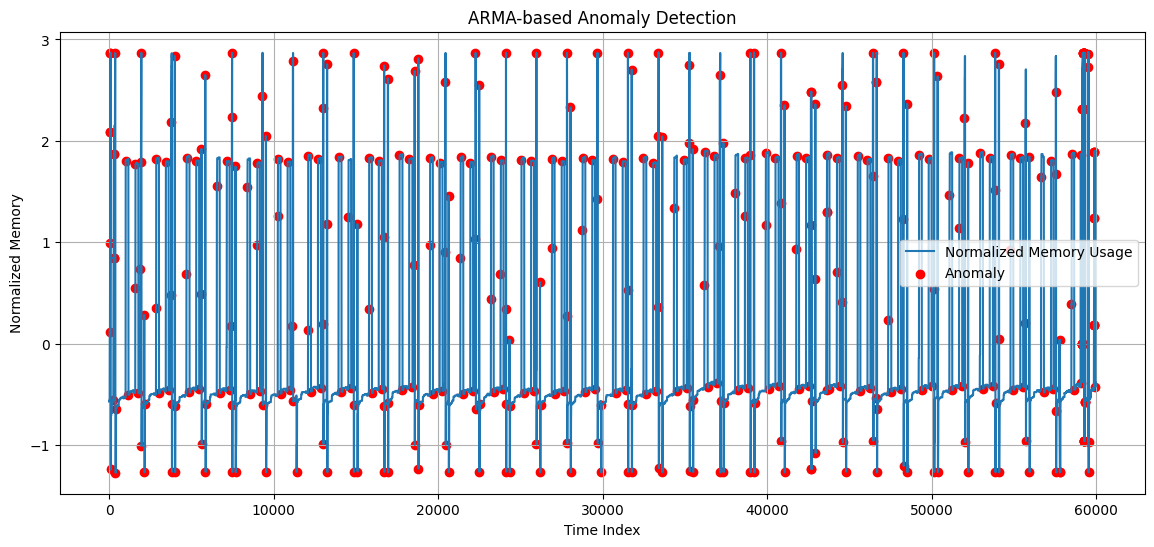

In [ ]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset again
df = pd.read_csv(r"C:\Users\vvaib\Downloads\k8s_metrics.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values(by='Timestamp')

# Use Memory Usage (you can switch this to CPU Load)
df['Anomaly'] = (df['Node Status'] != "Running").astype(int)
series = df['Memory Usage'].copy()

# Normalize the series (optional, for stability)
series = (series - series.mean()) / series.std()

# %%
# Fit ARMA model (ARMA(p,q) is equivalent to ARIMA(p,0,q))
# Try ARMA(2,2) as a starting point
model = ARIMA(series, order=(2, 0, 2))
model_fit = model.fit()

# Forecast (in-sample predictions)
predictions = model_fit.predict(start=0, end=len(series)-1)

# Residuals
residuals = series - predictions

# Anomaly detection threshold (e.g., 3 standard deviations)

# %%
# Plotthreshold = 3 * residuals.std()
anomalies = (np.abs(residuals) > threshold).astype(int)

# Ground truth
y_true = df['Anomaly'].values

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_true, anomalies))
print("\nClassification Report:")
print(classification_report(y_true, anomalies, digits=4))

plt.figure(figsize=(14,6))
plt.plot(series.index, series, label='Normalized Memory Usage')
plt.scatter(series.index[anomalies == 1], series[anomalies == 1], color='red', label='Anomaly')
plt.title("ARMA-based Anomaly Detection")
plt.xlabel("Time Index")
plt.ylabel("Normalized Memory")
plt.legend()
plt.grid(True)
plt.show()


In [126]:
predictions = model_fit.predict(start=0, end=len(series)-1)

# Residuals
residuals = series - predictions

# Anomaly detection threshold (e.g., 3 standard deviations)

# %%
# Plotthreshold = 3 * residuals.std()
anomalies = (np.abs(residuals) > 0.01).astype(int)

# Ground truth
y_true = df['Anomaly'].values

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_true, anomalies))
print("\nClassification Report:")
print(classification_report(y_true, anomalies, digits=4))

Confusion Matrix:
 [[38824 20420]
 [   97   613]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9975    0.6553    0.7910     59244
           1     0.0291    0.8634    0.0564       710

    accuracy                         0.6578     59954
   macro avg     0.5133    0.7594    0.4237     59954
weighted avg     0.9860    0.6578    0.7823     59954

